In [5]:
import torch
import tensorflow_datasets as tfds
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn import (
    model_selection, datasets, feature_extraction, pipeline, naive_bayes, metrics, svm, 
    decomposition, preprocessing, ensemble, utils, linear_model
)
import matplotlib.pyplot as plt
import torch

In [2]:
ds = tfds.load(name='imdb_reviews', split='train', shuffle_files=True)

In [3]:
ds_test = tfds.load(name='imdb_reviews', split='test', shuffle_files=True)

In [4]:
def get_dataset_data(ds):
  text_list = []
  labels = []
  for example in ds:
    text_list.append(example['text'].numpy().decode('UTF-8'))
    labels.append(example['label'].numpy())

  return text_list, labels

In [5]:
train_text_list, train_labels = get_dataset_data(ds)

In [6]:
test_text_list, test_labels = get_dataset_data(ds_test)

In [7]:
stop_words = nltk.corpus.stopwords.words('english')

In [8]:
def tokenize_text(text):
    tokens = []
    for word in word_tokenize(text):
            if len(word) < 2 or word.lower() in stop_words:
                continue
            tokens.append(word.lower())
    return tokens

In [9]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in tokenize_text(articles)]

In [10]:
lemma_tokenizer = LemmaTokenizer()

train_text_tokens = []
for text in train_text_list:
  train_text_tokens.append(tokenize_text(text))

In [11]:
test_text_tokens = []
for text in test_text_list:
  test_text_tokens.append(tokenize_text(text))


In [12]:
model = pipeline.Pipeline([
    ('counts', feature_extraction.text.CountVectorizer(
        lowercase=True,
        tokenizer=LemmaTokenizer(),
        min_df=2,
        ngram_range=(1,2),
    )),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('svm', svm.LinearSVC())
]
)

In [13]:
model.fit(train_text_list, train_labels)

Pipeline(steps=[('counts',
                 CountVectorizer(min_df=2, ngram_range=(1, 2),
                                 tokenizer=<__main__.LemmaTokenizer object at 0x10c3c5250>)),
                ('tfidf', TfidfTransformer()), ('svm', LinearSVC())])

f1_score = 0.89


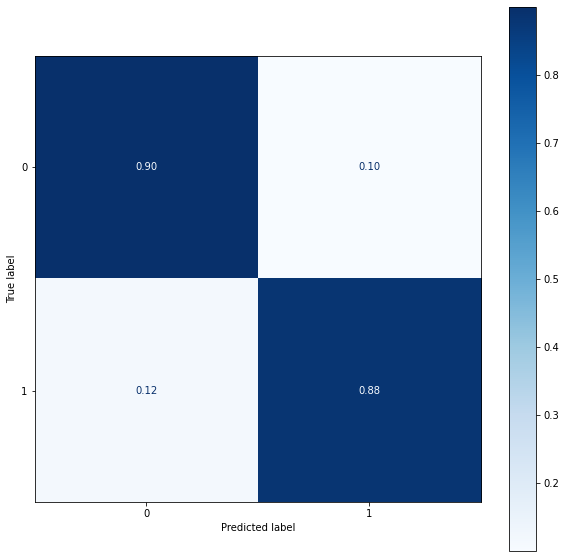

In [14]:
y_pred = model.predict(test_text_list)

fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(model, test_text_list, test_labels, ax = ax, cmap='Blues', normalize='true', values_format='.2f')

score = metrics.f1_score(test_labels, y_pred, average='weighted')

print(f'f1_score = {score:.2f}')

In [13]:
from gensim.models.wrappers import FastText
import gensim

In [14]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip

--2021-04-30 20:25:57--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587879973 (561M) [application/zip]
Saving to: ‘wiki-news-300d-1M-subword.vec.zip.2’

wiki-news-300d-1M-s 100%[===================>] 560.65M  4.51MB/s    in 2m 17s  

2021-04-30 20:28:16 (4.08 MB/s) - ‘wiki-news-300d-1M-subword.vec.zip.2’ saved [587879973/587879973]



In [15]:
!unzip wiki-news-300d-1M-subword.vec.zip

Archive:  wiki-news-300d-1M-subword.vec.zip
replace wiki-news-300d-1M-subword.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [16]:
import gensim.models.wrappers.fasttext
model = gensim.models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M-subword.vec', binary=False, encoding='utf8')

In [17]:
word_vectors = model.wv

<ipython-input-17-aa19759b2b96>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors = model.wv


In [18]:
del model

In [19]:
word_vectors.most_similar('hi')

[('hello', 0.6933997869491577),
 ('heyy', 0.6434062719345093),
 ('heyyy', 0.6397197246551514),
 ('hiya', 0.6382022500038147),
 ('heyyyy', 0.6244087219238281),
 ('Hi', 0.622696042060852),
 ('hiiii', 0.6143085956573486),
 ('hey', 0.6041119694709778),
 ('Heyyy', 0.6016119718551636),
 ('hey.', 0.6001185178756714)]

In [20]:
train_reviews_word_embeddings = []

for tokens in train_text_tokens:
  review_word_embeddings = []
  for token in tokens:
    try:
      review_word_embeddings.append(word_vectors[token])
    except:
      pass
  train_reviews_word_embeddings.append(torch.tensor(review_word_embeddings))

In [21]:
test_reviews_word_embeddings = []

for tokens in test_text_tokens:
  review_word_embeddings = []
  for token in tokens:
    try:
      review_word_embeddings.append(word_vectors[token])
    except:
      pass
  test_reviews_word_embeddings.append(torch.tensor(review_word_embeddings))

In [22]:
train = torch.nn.utils.rnn.pad_sequence(train_reviews_word_embeddings + test_reviews_word_embeddings, batch_first=True)

In [23]:
train.shape

torch.Size([50000, 1418, 300])

In [24]:
X_train = train[:25000]

In [25]:
X_train.shape

torch.Size([25000, 1418, 300])

In [26]:
X_test = train[25000:]

In [27]:
X_test.shape

torch.Size([25000, 1418, 300])

In [6]:
from torch import nn
import torch.nn.functional as F

In [13]:
kernels = [2,3,4,5]
out_channels = 30
in_channels = 1
pads = [(0,0,1,0), (0,0,1,1), (0,0,2,1), (0,0,2,2)]
sentence_len = 1418
word_embedding_len = 300

In [32]:
class TextCNN(nn.Module):
    
    def __init__(self, kernels, out_channels, in_channels, pads, sentence_len, word_embedding_len):
        
        self.kernels = kernels
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.pads = pads
        self.sentence_len = sentence_len
        self.word_embedding_len = word_embedding_len
        
        super(TextCNN, self).__init__()
        
        
        self.convs = [nn.Conv2d(self.in_channels, self.out_channels, (self.kernels[0], self.word_embedding_len))
        , nn.Conv2d(self.in_channels, self.out_channels, (self.kernels[1], self.word_embedding_len))
        , nn.Conv2d(self.in_channels, self.out_channels, (self.kernels[2], self.word_embedding_len))
        , nn.Conv2d(self.in_channels, self.out_channels, (self.kernels[3], self.word_embedding_len))]
        
        self.label = nn.Linear(len(kernels)*out_channels, 1)
        
        
    def conv_block(self, input, conv_num):
        conv_out = self.convs[conv_num](F.pad(input, self.pads[conv_num])).squeeze()
        activation = F.relu(conv_out)
        max_out = F.max_pool1d(activation, activation.size()[2])

        return max_out
                                        
                                        
    def forward(self, input):
        
        input = input.unsqueeze(1)
        
        max0 = self.conv_block(input, 0)
        max1 = self.conv_block(input, 1)
        max2 = self.conv_block(input, 2)
        max3 = self.conv_block(input, 3)
        
        
        all_out = torch.cat((max0, max1, max2, max3), 1).squeeze()
                
        dropout = F.dropout(all_out)
        
        return self.label(dropout) 

In [33]:
model = TextCNN(kernels, out_channels, in_channels, pads, sentence_len, word_embedding_len)

In [34]:
model.forward(torch.randn(20, 1450, 300))

tensor([[-0.5173],
        [-1.7124],
        [-3.1247],
        [-1.4851],
        [ 0.2414],
        [-2.2319],
        [-1.4078],
        [-3.7801],
        [-2.7796],
        [-2.8123],
        [-2.1383],
        [-0.2863],
        [-2.6031],
        [-1.7019],
        [-1.2565],
        [-2.7556],
        [-3.4386],
        [-1.6612],
        [-2.1990],
        [-2.5003]], grad_fn=<AddmmBackward>)